## Gaussian Mixture Models

Resources:
- https://youtu.be/qMTuMa86NzU
- https://youtu.be/ZBLyXgjBx3Q

Reference: https://scikit-learn.org/stable/modules/mixture.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

### Part 1: Gaussian Mixture Models

We'll attempt to solve the task of background subtraction using Gaussian Mixture Models. Before that, you will need to implement the Gaussian Mixture Model algorithm from scratch.

Some details:
- Try to implement GMMs using Multi-variate Gaussian Distributions, the following tasks in the assignment are possible to implement using the Univariate version too but it might be bit inaccurate as explained below.
    - To clarify further, we could treat each pixel in our RGB image as our data point with [R, G, B] channels as the dimensions to the Multi-variate data point, and we would easily get predictions for each pixel location using Multi-variate approach.
    - Or, we could treat every single value in the given RGB image as a data point independent of what channel the belong to and consider them as Uni-variate data point, and get prediction using the Uni-variate approach.
    But this affects our prediction, since we can't simply make per pixel predtions anymore, because for every pixel location we would now have 3 different predictions.
    - To get around this, you could convert your image to Grayscale and then we would only have one channel/value corresponding to each pixel location, which would now allow us to use the Uni-variate approach for prediction, but this also means loss in information which would affect our quality of predictions.
    - Try to have a class based implementation of GMM, this would really help you in Background Subtraction task. You can get some general ideas on how to structure your class by looking at `sklearn.mixture.GaussianMixture` documentation and source code.
- The following code cell has a rough template to get you started with the implementation. You are free to change the structure of the code, this is just a suggestion to help you get started.


TLDR: You may implement the univariate version of GMMs, but it might not be as accurate as the multivariate version and it is recommended to try and implement the multivariate version.

In [ ]:
from scipy.stats import multivariate_normal

class GMM(object):
    def __init__(self, n_components=1, tol=1e-3, max_iter=100):
        """
        n_components: The number of mixture components.
        tol: The convergence threshold
        """
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.weights = None
        self.means = None
        self.covars = None

    def initialize_params(self, X):
        """
        X : A collection of `N` training data points, each with dimension `d`.
        """
        n_samples, n_features = X.shape
        self.weights = np.ones(self.n_components) / self.n_components
        np.random.seed(0)
        chosen = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[chosen]
        self.covars = np.array([np.cov(X.T) + self.tol*np.identity(n_features) for _ in range(self.n_components)])

    def E_step(self, X):
        """
        Find the Expectation of the log-likelihood evaluated using the current estimate for the parameters.
        """
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        for i in range(self.n_components):
            responsibilities[:, i] = self.weights[i] * multivariate_normal.pdf(X, mean=self.means[i], cov=self.covars[i])
        sum_responsibilities = responsibilities.sum(axis=1)[:, np.newaxis]
        responsibilities /= sum_responsibilities
        return responsibilities

    def M_step(self, X, responsibilities):
      """
      Updates parameters maximizing the expected log-likelihood found on the E step.
      """
      Nk = responsibilities.sum(axis=0)
      self.weights = Nk / Nk.sum()
      self.means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
      for i in range(self.n_components):
          diff = X - self.means[i]
          self.covars[i] = np.dot(responsibilities[:, i] * diff.T, diff) / Nk[i]
          self.covars[i] += self.tol * np.identity(X.shape[1])


    def fit(self, X, y=None):
        """
        Fit the parameters of the GMM on some training data.
        """
        self.initialize_params(X)
        log_likelihood = 0
        for _ in range(self.max_iter):
            responsibilities = self.E_step(X)
            self.M_step(X, responsibilities)
            new_log_likelihood = np.sum(np.log(np.sum([self.weights[k] * multivariate_normal.pdf(X, self.means[k], self.covars[k]) for k in range(self.n_components)], axis=0)))
            if np.abs(new_log_likelihood - log_likelihood) <= self.tol:
                break
            log_likelihood = new_log_likelihood

    def predict(self, X):
        """
        Predict the labels for the data samples in X using trained model.
        """
        responsibilities = self.E_step(X)
        return np.argmax(responsibilities, axis=1)

### Part 2: Background Subtraction

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly.

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Most of the time, the Gaussian with the higher weight corresponds to the background.
    - We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to the first baseline above.
    - To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    - This method is much simpler to implement but, this could give worse results.

#### Extracting Frames from videos

In [ ]:
source_folder = 'videos'
video = 'traffic.gif'

source_path = f'./{source_folder}/{video}'

In [ ]:
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"

In [ ]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [ ]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > /dev/null ;

#### Loading Frames

In [ ]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = np.asarray(img, dtype=np.float64)
    img /= 255.0

    frames.append(img)

frames = np.asarray(frames, dtype=np.float64)

#### Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False)

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


Note: You may use helper libraries like `imageio` for working with GIFs.

```python
import imageio

def make_gif(img_list, gif_path, fps=10):
    imageio.mimsave(gif_path, img_list, fps=fps)
    return
```

#### Frame Averaging

Extract Background Image from the training data and display it.

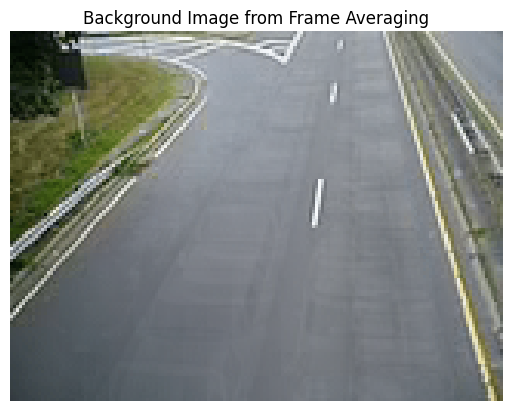

In [ ]:
import numpy as np

# train_frames is a NumPy array of shape (num_frames, height, width, channels)
background_image_avg = np.mean(train_frames, axis=0)

# Display the background image
import matplotlib.pyplot as plt

plt.imshow(background_image_avg)
plt.title('Background Image from Frame Averaging')
plt.axis('off')
plt.show()


#### GMMs per pixel

Create Set of GMMs for every pixel and fit them considering every training frame

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize the background model with zeros, having the same dimensions as an individual frame
background_image_gmm_custom = np.zeros((train_frames.shape[1], train_frames.shape[2], 3))

for i in range(train_frames.shape[1]):  # Height of the frame
    for j in range(train_frames.shape[2]):  # Width of the frame
        # Collect RGB values for the current pixel across all frames
        pixel_values = train_frames[:, i, j, :].reshape(-1, 3)  # Reshape to fit the GMM

        # Initialize and fit custom GMM to the pixel values
        gmm = GMM(n_components=2)
        gmm.fit(pixel_values)

        # Select the mean of the Gaussian component with the highest weight
        background_index = np.argmax(gmm.weights)
        background_pixel_value = gmm.means[background_index]

        # Assign this mean as the background value for the current pixel
        background_image_gmm_custom[i, j, :] = background_pixel_value

[link text](https://)
#### Extract Background Image from the trained model

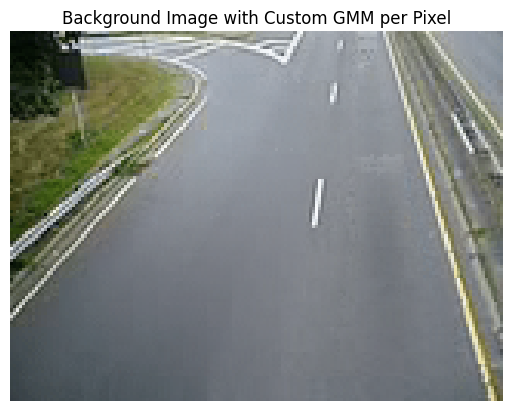

In [ ]:
# Display the extracted background image using custom GMM
plt.imshow(background_image_gmm_custom)
plt.title('Background Image with Custom GMM per Pixel')
plt.axis('off')
plt.show()

### Outputs

You can use the helper functions given below to display and save frames as videos, feel free to change them accordingly.

In [ ]:
# helper functions
from google.colab.patches import cv2_imshow

def display_frames(frames, fps=10.0):
    """
    Display the frames as a video.
    """
    eps = 0.0001

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2_imshow(frame)
        cv2.waitKey(int(1000 / fps))  # Wait between each frame
    cv2.destroyAllWindows()

def save_frames_colab(frames, fps=10.0, output_path='./results', file_name='background'):
    """
    Save the frames as a video .
    """
    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    save_path = os.path.join(output_path, f"{file_name}.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for frame in frames:
        # Normalize and convert the frame for saving
        frame = cv2.normalize(frame, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        frame = frame.astype(np.uint8)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        video_writer.write(frame)

    video_writer.release()

#### Frame Averaging

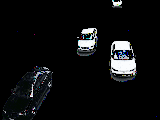

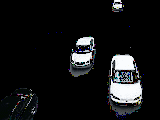

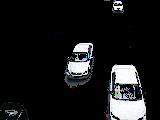

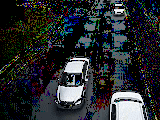

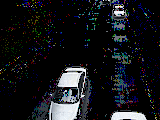

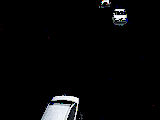

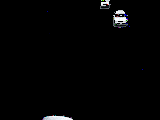

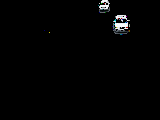

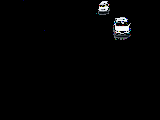

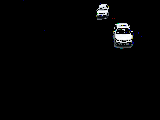

In [ ]:
def foreground_extraction(test_frames, background_image, threshold_value=0.2):
    """
    Extracts the foreground by subtracting the background and applying a threshold.

    Args:
    - test_frames (numpy array): The test frames as a numpy array.
    - background_image (numpy array): The background image to subtract.
    - threshold_value (float): The threshold to apply after subtraction.

    Returns:
    - numpy array: The foreground frames.
    """
    foreground_frames = []
    for frame in test_frames:
        # Subtract the background
        diff = np.abs(frame - background_image)

        # Normalize the difference
        diff_normalized = diff / diff.max()

        # Threshold
        mask = diff_normalized > threshold_value
        foreground = np.where(mask, frame, 0)  # Apply mask to frame

        foreground_frames.append(foreground)

    return np.array(foreground_frames)

# Extract foreground frames
threshold_value = 0.2
foreground_frames = foreground_extraction(test_frames, background_image_avg, threshold_value)

# Display the first few foreground frames as a video
display_frames(foreground_frames[:10], fps=10.0)

# Save the foreground frames as a video
save_frames_colab(foreground_frames, fps=10.0, output_path='./results', file_name='foreground_frame_averaging')


#### GMMs per pixel

In [ ]:
def extract_foreground_frames(test_frames, background_image, threshold=0.2):
    """
    Extract foreground by subtracting the background and applying a threshold.

    Args:
    - test_frames (numpy array): Test video frames.
    - background_image (numpy array): The extracted background image.
    - threshold (float): Threshold value for foreground extraction.

    Returns:
    - numpy array: The foreground frames.
    """
    foreground_frames = []
    for frame in test_frames:
        # Subtract background
        foreground = np.abs(frame - background_image)

        # Normalize and threshold
        foreground_norm = np.clip(foreground, 0, 1)
        mask = foreground_norm > threshold
        foreground_frame = np.where(mask, frame, 0)  # mask appling

        foreground_frames.append(foreground_frame)

    return np.array(foreground_frames)

# Extract the foreground frames using the test frames and the background model
foreground_frames = extract_foreground_frames(test_frames, background_image_gmm_custom, threshold=0.2)

# Save the foreground frames as a video
save_frames_colab(foreground_frames, fps=10.0, output_path='./results', file_name='foreground_GMM')